In [1]:
##import all the required libraries
import pandas as pd
import numpy as np
import unicodedata
import nltk
import seaborn as sns
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from gensim.models import word2vec
from sklearn import manifold
import itertools
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim import models
from gensim import similarities

C:\Users\AMRINA\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AMRINA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
train = pd.read_csv("data/resep_dataset2.csv")
train.Bahan.head()

0    Ayam, potong jadi 10 bagian  -  900 gram Garam...
1    Tepung tapioka  -  150 gram Tepung terigu  -  ...
2    Kangkung  -  1 ikat Kacang panjang  -  1 ikat ...
3    Kuning telur  -  4 butir Minyak goreng  -  40 ...
4    Telur  -  4 butir Gula pasir  -  70 gram Emuls...
Name: Bahan, dtype: object

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Judul   1353 non-null   object
 1   Url     1353 non-null   object
 2   Bahan   1353 non-null   object
 3   Step    1353 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


In [5]:
def clean_number(text):
    text = re.sub(r'\w*\d+\w*', '', str(text))
    return text

In [6]:
#casefolding
def token_lower(text):
    text = ''.join(str(text)).lower() # lowercase text
    return text

#Remove Puncutuation
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z]')
def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    return text

#menghapus double atau lebih whitespace
def _normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")


In [7]:
#stopword
#clean stopwords
stopwords_indonesian = set(stopwords.words('indonesian'))

takaran = ['gram', 'sdt', 'sdm', 'buah', 'ml', 'mililiter', 'cup', 'gelas', 'tsp', 'tbsp', 'liter', 'g', 'kg',
           'kilogram', 'pound', 'ons', 'pint', 'pt', 'c', 'celcius', 'f', 'fahrenheit', 'derajat', 'm', 'meter',
           'mm', 'milimeter', 'ruas', 'cm', 'centimeter', 'senti', 'centi', 'siung', 'lembar', 'tangkai', 'batang',
           'butir', 'slice', 'keping', 'kotak', 'papan', 'genggam', 'sejumput', 'bungkus', 'sachet', 'dcc', 'piring',
           'cincin', 'grambahan', 'sendok', 'porsi', 'kantung', 'kantong', 'scoop', 'skup', 'scop', 'loyang', 'segenggam',
           'buntil', 'ikat', 'double', 'botol', 'pack', 'siung','diameter', 'ekor', 'kuntum', 'bonggol']

word_to_remove = [ "ditorch", "korea", "lembut", "fillet", "gula", "oles", "protein", "tinggi", "rendah",
                  "sedang", "bersih", "sela", "tambah", "oles", "leleh", "kukus", "marinasi", "mangkuk",
                  "ukur", "hancur", "wadah", "celup", "adaan", "kedalam","sesuai", 'berat', 'bola', 'basah',
                  'bilas', 'buahsaus', 'kapal', 'selam', 'gurih', 'pisah', 'bantu', 'suir', 'hancur', 'tangan', 
                  'buahlainnya', 'bagus', 'kualitas', 'sejumputkulit', 'tetessaus', 'putus', 'larut', 'olesisian', 
                  'dimemarkan', 'memar',  'bumbu', 'kuah', 'ambil', 'matang', 'belah', 'bulat', 'sangrai', 'jari', 
                  'mentah', 'air', 'cair', 'geprek', 'tipis', 'butirkuah', 'adon', 'rendam', 'tumbuk', 'lengkap', 
                  'selera', 'sesuai', 'b', 'blender', 'of', 'campur', 'sdtserundeng', 'cacah', 'diam', 'tbmsp', 
                  'kaku', 'siram', 'kotor', 'kain', 'saring', 'aneka', 'cocolan', 'dingin', 'celup', 'hias', 
                  'gepeng', 'serut', 'sdtsaus', 'sdtbaluran', 'formula', 'secukupnyaisian', 'gramisi', 
                  'sdttopping', 'pipil', 'didih', 'bentuk', 'ulek', 'remas', 'sisa', 'larut', 'siram', 'opsional',
                  'cetak', 'tiris', 'direbus', 'disangrai', 'i', 'ii', 'iii', 'iv', 'lebih', 'susut', 'lebar', 
                  'diiikat', 'mudah', 'sikat', 'luar', 'geprak', 'tintanya', 'perlembar',   'diseduh', 'batangsaus',
                  'acting', 'secukupnyatumisan', 'secukupnyalainnya', 'secukupnyakaldu', 'lembarlainnya', 'persannya', 
                  'ekorbumbu', 'buahkuah', 'sisir', 'adon', 'tumis', 'encerkan', 'oles', 'sela', 'tambah', 'lelehkan', 
                  'serong', 'garam', 'minyak', 'bahan', 'a', 'potong', 'ikat', 'pasir', 'goreng', 'optional', 'butir', 
                  'jam', 'kupas', 'jenis', 'jala', 'ready', 'to', 'rambut', 'biar', 'asap', 'protein', 'rendah', 'tinggi', 
                  'bersih', "simpul", 'lauk', 'pecel', 'hancur', 'baluran', 'didih', 'papanpelapis', 'ampas', 'siungbumbu', 
                  'dibagi', 'bagi', 'suir', 'sdtlainnya', 'lengkap', 'ukur', 'lulur', 'biar', 'lapis', 'sesuai', 'isi', 
                  'tambah', 'rekat', 'lawan', 'serat', 'lumatkan', 'kerok', 'pecah', 'potong',  'lihat', 'resep', 'versi', 
                  'rasa', 'bunda', 'iris', 'suwir', 'lengkap', 'rendam', 'isi', 'dadu', 'literlainnya', 'secukupnyisi', 
                  'dasar', 'secukupnyaes', 'kondisi', 'kulkas', 'sdtmerebus', 'secukupnyabubur', 'sdtcuko', 'pembalur', 
                  'menggoreng', 'mlisi', 'mlpelengkap', 'mlsambal', 'sdtpencelup', 'siungpelapis', 'api', 'wajan', 'anti', 
                  'lengket', 'gigi', 'tusuk',  'menyerong', 'iris', 'kerat', 'buahbahan', 'gramlapisan', 'panas', 
                  'secukupnyaperendam', 'buahpencelup', 'basic', 'hasil', 'merebus', 'instan', 'hangat', 'petik', 'korek', 
                  'plastik', 'pilih', 'seduh', 'suhu', 'ruang', 'mlfilling', 'sdtgarnish', 'garnish', 'sdtsambal', 
                  'lembartaburan', 'minimal', 'secukupnyalapisan', 'kuku', 'jaripelengkap', 'perasannya', 'campur', 'lumur', 
                  'ayak', 'menyemat', 'filling', 'orak', 'arik', 'cairkan', 'menit','air', 'sdtperendam', 'mengungkep', 
                  'mengunkep', 'aduk', 'mlsaus', 'secukupnyabiang', 'lumur', 'mlbahan', 'sdtbahan', 'lumuran', 'sdttaburan', 
                  'sdmtaburan', 'gramtaburan', 'robek', 'sd', 'tlapisan', 'kasur', 'tali', 'lembarpudding', 'alas', 'lentur', 
                  'sejumpuhkuah', 'sdmserundeng', 'sdtolesan', 'mltaburan', 'taburan', 'tabur', 'cepat', 'kolcuciwis', 
                  'hangatkan', 'lembarbumbu', 'serutan', 'didih', 'lilit', 'campur', 'saring', 'variasi', 'cabut', 'goyang', 
                  'seger', 'beli', 'dibentuk', 'seujung', 'pekat', 'dipulung',  'setengah', 'tua', 'es', 'cincang', 'halus', 
                  'memarkan', 'secukupnya', 'rajang', 'kasar', 'sampai', 'siangi', 'cuci', 'hancur', 'empuk', 'segar', 'celup', 
                  'sobek', 'dingin', 'tengah', 'lebar', 'lidi', 'simpukan', 'simpul', 'kocok', 'kocock', 'lepas', 'tabur', 
                  'konsistensi', 'duri', 'goreng', 'minyak', 'rekat', 'makan', 'tiris', 'panas', 'rebus', 'perasan', 'semalaman', 
                  'tabur', 'pakai', 'buang', 'tumis', 'rebusan', 'topping', 'sdmbahan', 'tusuk', 'mltopping', 'diblender', 'lapis', 
                  'spread', 'biar', 'encer', 'kasir', 'utuh', 'larutkan', 'tumis', 'endapan', 'peta', 'sdmcuko', 'tetes', 'uleg', 
                  'sdmisi', 'kupas', 'sdmuleg', 'beserta', 'berseta', 'sebentar', 'goreng', 'aluminium', 'foil', "pera", "tengah", 
                  "isi", "encer", "peras","tebal","tiris", "lawan", "puter","pisah", "tambah", "jambal", "didih", "tahan", "penuh", 
                  "tahan", "tumbuk","panggang", "ikat", "bening", "mekar", "kotor", "saring", "goreng", "oil"
                 ]

def clean_stopwords(text):
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in stopwords_indonesian and
                     word.lower() not in takaran and word.lower() not in word_to_remove]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

In [8]:
import simplemma
def lemmatization(text):
    text = ' '.join(simplemma.lemmatize(word, lang='id') for word in text.split() if word in text)
    return text 

In [9]:
from nltk.tokenize import word_tokenize

def tokenize_sentence(sentence):
    multi_word_tokens = [
        "bawang merah", "bawang putih", "tepung terigu", "tepung tapioka", "tepung maizena", "baking powder",
        "cabai merah", "bawang bombay", "cabai rawit", "jeruk nipis", "daun jeruk","asam jawa", "daun salam", 
        "brown sugar", "jeruk limau", "nata de coco", "kapur sirih", "whipping cream", "buah naga", "kaldu bubuk", 
        "daun kari", "cabai merah", "daun bawang", "daun pandan", "daun pisang", "gula merah", "kecap manis", "ketan hitam", 
        "cabai hijau", "susu bubuk", "kacang panjang", "cabai rawit merah","kelapa parut", "gula bubuk", "rumput laut", 
        "bawang bombai", "kacang tanah", "kecap inggris", "kecap asin", "gula aren", "daging ayam", "dada ayam", "daging sapi", 
        "kaldu ayam bubuk", "ceker ayam", "usus ayam", "telur ayam", "sayap ayam", "ayam kampung", "paha ayam", "iga sapi", 
        "tulang ayam", "sosis ayam", "ati ampela", "daging sapi has dalam", "ati ampela ayam", "ayam jantan", "ikan tenggiri", 
        "ikan nila", "kembang tahu", "ikan kembung", "ikan mujair", "ikan mas", "ikan bandeng", "ikan selar", "ikan teri", 
        "ikan gabus", "ikan patin", "ikan tuna", "ikan tongkol", "ikan cakalang", "ikan salmon", "ikan salai", "ikan lele", 
        "ikan gurame", "ikan kakap", "telur ikan", "ikan bawal", "ikan kerapu", "ikan peda", "ikan salem", "ikan asin", 
        "jamur kancing", "jamur kuping", "ikan dori", "ikan pe", "jamur hioko", "jamur enoki", "jamur shitake", "jamur champignon", 
        "jamur tiram", "jamur merang", "saus tiram", "kecap manis", "tepung beras", "tepung sagu", "tepung roti", "tape singkong", 
        "kulit pangsit", "kulit lumpia","soda kue", "pisang tanduk", "tepung panir", "pisang kepok", "pisang ambon", "tulang rangu",
        "tetelan sapi", "tepung ketan putih", "whipping cream", "cream cheese", "pisang raja", "tepung kanji", "tepung hunkwe",
        "unsalted butter", "pisang kapok", "pisang kepok", "ragi instant", "daging kambing", "kaldu jamur", "kaldu jamur bubuk", 
        "daging sapi sandung lamur", "urat sapi", "kaki sapi", "iga kambing", "tulang kambing", "kaki kambing", "jeroan kambing",
        "kikil sapi", "daun kunyit", "kuning telur", "putih telur", "daun seledri", "abon ayam", "abon sapi", "tulang rangu",
        "kaldu sapi", "lidah sapi", "bakso sapi", "bakso ayam", "sosis sapi", "babat sapi", "susu sapi", "buntut sapi", "hati sapi",
        "paru sapi", "daging sapi has dalam", "keju cheddar", "agar agar", "kental manis", "cabe keriting", "smoked beef", "keju parmesan",
        "keju mozarella", "susu cair", "keju edam", "keju slice", "cheese spread", "choco chips", "palm sugar", "kacang tanah", "kayu manis", 
        "saus tiram", "daun ketumbar", "pisang uli", "pisang mas", "pisang tanduk", "beras ketan putih", "tepung ketan", "tepung sagu", "beras ketan",
        "tepung beras", "pisang candi", "kulit pastry", "jantung pisang", "petis udang", "tahu putih", "tahu kuning", "tahu coklat", "pisang lilin", 
        "selai coklat", "selai strawberry", "sawi putih", "selai kacang", "selai nanas", "cumi cumi", "saus tomat", "beras jagung", "beras basmati",
        "ubi merah", "ubi ungu", "ubi cilembu", "ubi jalar", "ubi kuning", "ubi orange", "kacang panjang", "kacang almond", "kacang kenari", "kolang kaling", 
        "kacang mede", "kacang polong", "sagu mutiara", "roti tawar", "daun pepaya", "kacang merah", "kacang hijau", "kacang kedelai", "kerang dara", "teri nasi", 
        "teri nasi medan", "teri medan", "bunga lawang", "daun melinjo", "jambu air", "kerang hijau", "ice cream", "daun singkong", "kelapa muda",
        "cabai merah besar", "cabai merah keriting", "kulit melinjo", "cabai hijau besar", "cabai hijau", "chia seed", "kol putih",
        "kol ungu", "sandung lamur", "daun kunyit", "bunga kol", "bunga cengkeh", "bunga sedap malam", "bunga kecombrang", "baby kol", 
        "bunga genjer", "asam kandis", "asam gelugur", "bunga pepaya", "kembang tahu", "kembang turi", "cooking cream", "baby buncis",
        "baby kailan", "baby cumi", "baby potato", "jeroan sapi", "baking soda", "saus tomat", "susu uht","susu kental manis", "jambu air", 
        "jambu biji merah", "daun mint", "jambu biji", "susu cair", "coklat bubuk", "cokelat bubuk", "merica bubuk", "krimer kental manis",
        "gula merah", "cabai rawit hijau", "bawang putih bubuk", "cabai bubuk", "pasta coklat", "pasta mocca", "cooking cream",
        "biskuit susu", "biskuit oreo", "biskuit marie regal","daun kol", "daging ayam", "kaldu ayam", "buah naga", "buah naga merah", "coklat putih",
        "biji selasih", "agar agar", "buah cherry", "belimbing sayur", "belimbing wuluh", "roti tawar", "usus ayam", "santan instan", "pala bubuk", "ketumbar bubuk", 
        "lada bubuk", "daun selada", "star anise", "daun singkong", "roti burger", "mangga kweni", "daun kunyit", "kentang goreng", "susu full cream", 
        "chicken katsu", "corn syrup", "krim whipping", "lidah buaya", "french fries", "timun suri", "bawang prei", "telur asin", "telur puyuh", "tepung sagu", 
        "daun pandan", "temu kunci", "kembang turi", "jeruk kasturi", "lemon cui", "tahu putih", "tahu kuning", "tahu sutra", "tahu cina", "tahu kulit", "tahu pong", 
        "tahu sumedang", "tahu jepang", "tahu gembos", "daun katuk", "daun cincau", "kacang kedelai", "quaker oat", "kacang hijau", "jantung pisang", 
        "melinjo merah", "melinjo hijau", "labu siam", "bunga pepaya", "tape ketan", "tape singkong", "tape ketan hitam", "cream of tartar", "soft cream",
        "butter cream", "Cake emulsifier", "Essence vanilla", "susu kedelai", "susu evaporasi", "telur bebek"
    ]
    unique_words = set()

    for token in multi_word_tokens:
        sentence = sentence.replace(token, token.replace(" ", "_"))

    words = word_tokenize(sentence)

    for i in range(len(words)):
        for token in multi_word_tokens:
            if " " in token and token in words[i]:
                unique_words.add(token)
            elif token == words[i]:
                unique_words.add(token)

    return list(unique_words)


In [10]:
from nltk.tokenize import word_tokenize

def tokenize_sentence(sentence):
    multi_word_tokens = [
        "bawang merah", "bawang putih", "tepung terigu", "tepung tapioka", "tepung maizena", "baking powder",
        "cabai merah", "bawang bombay", "cabai rawit", "jeruk nipis", "daun jeruk","asam jawa", "daun salam", 
        "brown sugar", "jeruk limau", "nata de coco", "kapur sirih", "whipping cream", "buah naga", "kaldu bubuk", 
        "daun kari", "cabai merah", "daun bawang", "daun pandan", "daun pisang", "gula merah", "kecap manis", "ketan hitam", 
        "cabai hijau", "susu bubuk", "kacang panjang", "cabai rawit merah","kelapa parut", "gula bubuk", "rumput laut", 
        "bawang bombai", "kacang tanah", "kecap inggris", "kecap asin", "gula aren", "daging ayam", "dada ayam", "daging sapi", 
        "kaldu ayam bubuk", "ceker ayam", "usus ayam", "telur ayam", "sayap ayam", "ayam kampung", "paha ayam", "iga sapi", 
        "tulang ayam", "sosis ayam", "ati ampela", "daging sapi has dalam", "ati ampela ayam", "ayam jantan", "ikan tenggiri", 
        "ikan nila", "kembang tahu", "ikan kembung", "ikan mujair", "ikan mas", "ikan bandeng", "ikan selar", "ikan teri", 
        "ikan gabus", "ikan patin", "ikan tuna", "ikan tongkol", "ikan cakalang", "ikan salmon", "ikan salai", "ikan lele", 
        "ikan gurame", "ikan kakap", "telur ikan", "ikan bawal", "ikan kerapu", "ikan peda", "ikan salem", "ikan asin", 
        "jamur kancing", "jamur kuping", "ikan dori", "ikan pe", "jamur hioko", "jamur enoki", "jamur shitake", "jamur champignon", 
        "jamur tiram", "jamur merang", "saus tiram", "kecap manis", "tepung beras", "tepung sagu", "tepung roti", "tape singkong", 
        "kulit pangsit", "kulit lumpia","soda kue", "pisang tanduk", "tepung panir", "pisang kepok", "pisang ambon", "tulang rangu",
        "tetelan sapi", "tepung ketan putih", "whipping cream", "cream cheese", "pisang raja", "tepung kanji", "tepung hunkwe",
        "unsalted butter", "pisang kapok", "pisang kepok", "ragi instant", "daging kambing", "kaldu jamur", "kaldu jamur bubuk", 
        "daging sapi sandung lamur", "urat sapi", "kaki sapi", "iga kambing", "tulang kambing", "kaki kambing", "jeroan kambing",
        "kikil sapi", "daun kunyit", "kuning telur", "putih telur", "daun seledri", "abon ayam", "abon sapi", "tulang rangu",
        "kaldu sapi", "lidah sapi", "bakso sapi", "bakso ayam", "sosis sapi", "babat sapi", "susu sapi", "buntut sapi", "hati sapi",
        "paru sapi", "daging sapi has dalam", "keju cheddar", "agar agar", "kental manis", "cabe keriting", "smoked beef", "keju parmesan",
        "keju mozarella", "susu cair", "keju edam", "keju slice", "cheese spread", "choco chips", "palm sugar", "kacang tanah", "kayu manis", 
        "saus tiram", "daun ketumbar", "pisang uli", "pisang mas", "pisang tanduk", "beras ketan putih", "tepung ketan", "tepung sagu", "beras ketan",
        "tepung beras", "pisang candi", "kulit pastry", "jantung pisang", "petis udang", "tahu putih", "tahu kuning", "tahu coklat", "pisang lilin", 
        "selai coklat", "selai strawberry", "sawi putih", "selai kacang", "selai nanas", "cumi cumi", "saus tomat", "beras jagung", "beras basmati",
        "ubi merah", "ubi ungu", "ubi cilembu", "ubi jalar", "ubi kuning", "ubi orange", "kacang panjang", "kacang almond", "kacang kenari", "kolang kaling", 
        "kacang mede", "kacang polong", "sagu mutiara", "roti tawar", "daun pepaya", "kacang merah", "kacang hijau", "kacang kedelai", "kerang dara", "teri nasi", 
        "teri nasi medan", "teri medan", "bunga lawang", "daun melinjo", "jambu air", "kerang hijau", "ice cream", "daun singkong", "kelapa muda",
        "cabai merah besar", "cabai merah keriting", "kulit melinjo", "cabai hijau besar", "cabai hijau", "chia seed", "kol putih",
        "kol ungu", "sandung lamur", "daun kunyit", "bunga kol", "bunga cengkeh", "bunga sedap malam", "bunga kecombrang", "baby kol", 
        "bunga genjer", "asam kandis", "asam gelugur", "bunga pepaya", "kembang tahu", "kembang turi", "cooking cream", "baby buncis",
        "baby kailan", "baby cumi", "baby potato", "jeroan sapi", "baking soda", "saus tomat", "susu uht","susu kental manis", "jambu air", 
        "jambu biji merah", "daun mint", "jambu biji", "susu cair", "coklat bubuk", "cokelat bubuk", "merica bubuk", "krimer kental manis",
        "gula merah", "cabai rawit hijau", "bawang putih bubuk", "cabai bubuk", "pasta coklat", "pasta mocca", "cooking cream",
        "biskuit susu", "biskuit oreo", "biskuit marie regal","daun kol", "daging ayam", "kaldu ayam", "buah naga", "buah naga merah", "coklat putih",
        "biji selasih", "agar agar", "buah cherry", "belimbing sayur", "belimbing wuluh", "roti tawar", "usus ayam", "santan instan", "pala bubuk", "ketumbar bubuk", 
        "lada bubuk", "daun selada", "star anise", "daun singkong", "roti burger", "mangga kweni", "daun kunyit", "kentang goreng", "susu full cream", 
        "chicken katsu", "corn syrup", "krim whipping", "lidah buaya", "french fries", "timun suri", "bawang prei", "telur asin", "telur puyuh", "tepung sagu", 
        "daun pandan", "temu kunci", "kembang turi", "jeruk kasturi", "lemon cui", "tahu putih", "tahu kuning", "tahu sutra", "tahu cina", "tahu kulit", "tahu pong", 
        "tahu sumedang", "tahu jepang", "tahu gembos", "daun katuk", "daun cincau", "kacang kedelai", "quaker oat", "kacang hijau", "jantung pisang", 
        "melinjo merah", "melinjo hijau", "labu siam", "bunga pepaya", "tape ketan", "tape singkong", "tape ketan hitam", "cream of tartar", "soft cream",
        "butter cream", "Cake emulsifier", "Essence vanilla", "susu kedelai", "susu evaporasi", "telur bebek", "bubuk spekuk"
    ]
    
        # Ganti multi-word tokens dengan versi yang memiliki underscore
    for token in multi_word_tokens:
        sentence = sentence.replace(token, token.replace(" ", "_"))

    # Tokenisasi kalimat berdasarkan spasi
    words = sentence.split()

    # Hilangkan duplikat
    unique_words = list(set(words))

    return unique_words

In [11]:
def bahan_parser(text):
    synonym_mapping = {
        'kubis': 'kol',
        'daun cengkeh': 'ceengkeh',
        'baby kol': 'cuciwis',
        'pekak': 'bunga lawang',
        'kembang lawang': 'bunga lawang',
        'kembang kol': 'bunga kol',
        'bawang bombay': 'bawang bombai',
        'terigu': 'tepung terigu',
        'maizena': 'tepung maizena',
        'tapioka': 'tepung tapioka',
        'kental manis': 'susu kental manis',
        'coklat': 'cokelat',
        'mete': 'kacang mete',
        'almond': 'kacang almond',
        'daun kol': 'kol',
        'daging ayam': 'ayam',
        'selasih': 'biji selasih',
        'agar': 'agar agar',
        'cherry': 'buah cherry',
        'belimbing sayur': 'belimbing wuluh',
        'santan instan': 'santan',
        'star anise': 'bunga lawang',
        'pete': 'petai',
        'bawang prei': 'daun bawang',
        'whipcream': 'whipping cream',
        'laos': 'lengkuas',
        'jeruk kasturi': 'lemon cui',
        'tahu sutra': 'tahu jepang',
        'whip cream': 'whipping cream',
    }

    text = clean_number(text)
    text = token_lower(text)
    text = clean_punct(text)
    text = _normalize_whitespace(text)
    text = clean_stopwords(text)
    text = lemmatization(text)
    text = tokenize_sentence(text)

    # Replace synonyms using the synonym mapping
    text = [synonym_mapping.get(word, word) for word in text]

    return text

In [12]:
train['clean']= train['Bahan'].apply(bahan_parser)

In [13]:
train['clean']

0       [jeruk_nipis, daun_jeruk, bawang_merah, putih,...
1       [tepung_terigu, cabai_bubuk, halus, tepung_tap...
2       [terong, kacang_tanah, kemiri, kangkung, merah...
3       [tepung_terigu, kuning_telur, putih_telur, cok...
4       [margarin, telur, pasta, moka, sela, strawberr...
                              ...                        
1348    [baking_powder, tepung_terigu, margarin, sp, t...
1349    [larut, ketumbar, halus, bawang_merah, kelapa,...
1350    [baking_powder, tepung_terigu, bubuk, telur, s...
1351    [butter, tepung_terigu, kuning_telur, keju_che...
1352    [daun_ketumbar, tomat, bawang_bombay, alpukat,...
Name: clean, Length: 1353, dtype: object

In [14]:
bahan_parser(train.clean[356])

['butter',
 'susu_bubuk_spekuk',
 'tepung_terigu',
 'kuning_telur',
 'kental_manis',
 'susu_bubuk']

In [15]:
train

,Judul,Url,Bahan,Step,clean
0,Resep Ayam Panidar,https://resepkoki.id/resep/resep-ayam-panidar/,"Ayam, potong jadi 10 bagian - 900 gram Garam...",Cuci bersih ayam kemudian marinasi dengan gara...,"[jeruk_nipis, daun_jeruk, bawang_merah, putih,..."
1,Resep Moring,https://resepkoki.id/resep/resep-moring/,Tepung tapioka - 150 gram Tepung terigu - ...,"Campur tepung tapioka, terigu, bawang putih, g...","[tepung_terigu, cabai_bubuk, halus, tepung_tap..."
2,Resep Serombotan Klungkung,https://resepkoki.id/resep/resep-serombotan-kl...,Kangkung - 1 ikat Kacang panjang - 1 ikat ...,Rebus masing-masing sayuran dengan sedikit gar...,"[terong, kacang_tanah, kemiri, kangkung, merah..."
3,Resep Hurricane Cake Roll,https://resepkoki.id/resep/resep-hurricane-cak...,Kuning telur - 4 butir Minyak goreng - 40 ...,"Bahan 1: Campur kuning telur dan susu cair, ad...","[tepung_terigu, kuning_telur, putih_telur, cok..."
4,Resep Bolu Gulung Batik,https://resepkoki.id/resep/resep-bolu-gulung-b...,Telur - 4 butir Gula pasir - 70 gram Emuls...,"Kocok telur, gula pasir dan emulsifier sampai ...","[margarin, telur, pasta, moka, sela, strawberr..."
...,...,...,...,...,...
1348,Resep Bolu Panggang Coklat,https://resepkoki.id/resep/resep-bolu-panggang...,Tepung terigu - 150 gram Baking powder - ...,Jadikan 1 semua bahan A dan ayak. Sisihkan.Sia...,"[baking_powder, tepung_terigu, margarin, sp, t..."
1349,Resep Dendeng Batokok,https://resepkoki.id/resep/resep-dendeng-batokok/,Air kelapa - 700 ml Daging sapi - 350 gra...,"Rebus daging tanpa di potong, dengan bumbu reb...","[larut, ketumbar, halus, bawang_merah, kelapa,..."
1350,Resep Kue Cubit,https://resepkoki.id/resep/resep-kue-cubit/,Tepung terigu protein rendah - 100 gram Rag...,"Campurkan semua bahan A, lalu aduk dengan spat...","[baking_powder, tepung_terigu, bubuk, telur, s..."
1351,Resep Kue Nastar Keju,https://resepkoki.id/resep/resep-kue-nastar-keju/,Tepung terigu protein sedang - 350 gram Sus...,"Kocok margarin, butter, dan gula halus dengan ...","[butter, tepung_terigu, kuning_telur, keju_che..."


In [16]:
train.to_csv('data/train_clean.csv')

In [17]:
#Code to generate bag of words from the cleaned ingredient list
bags_of_words = [Counter(bahan_parser(Bahan)) for Bahan in train.Bahan]

In [18]:
#Find sum of every ingredient using Counter()
sumbags = sum(bags_of_words, Counter())


# Finally, plot the 10 most used ingredients
clean_df = pd.DataFrame.from_dict(sumbags, orient='index').reset_index()
clean_df = clean_df.rename(columns={'index':'Bahan', 0:'count'})
clean_df.to_csv('data/ingredient_clean.csv')

top_ing = clean_df.sort_values('count', ascending=False)

In [19]:
clean_df

,Bahan,count
0,jeruk_nipis,163
1,daun_jeruk,205
2,bawang_merah,468
3,putih,132
4,serai,211
...,...,...
975,kaki,1
976,tunjang,1
977,mocca,1
978,essense,1


In [20]:
ingr_only_dict = clean_df['Bahan'].to_dict()

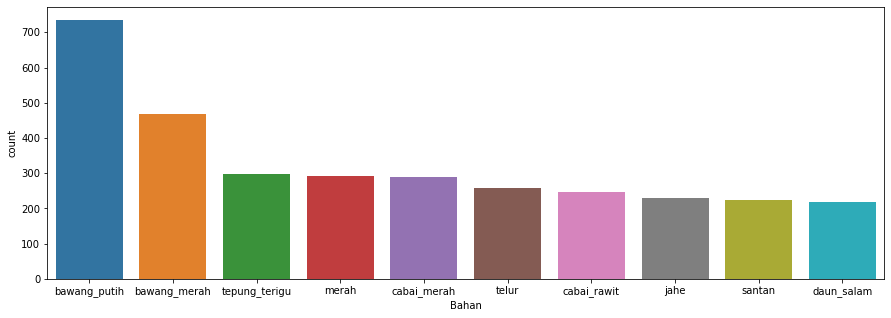

In [21]:
#Plot top ingredients using bag of words
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(x = 'Bahan', y = 'count', data = top_ing.head(10))
sns.set_palette("deep")
plt.show()
fig.savefig('ingredient_count_bag_of_words.png')

In [22]:
#Get all clean ingredients in list format per recipe
ingr_list = []
for Bahan in train.Bahan:
    ingr_list.append(bahan_parser(Bahan))

In [23]:
print (ingr_list[0])

['jeruk_nipis', 'daun_jeruk', 'bawang_merah', 'putih', 'serai', 'merah', 'andaliman', 'kelapa_parut', 'ayam', 'bawang_putih', 'jahe', 'cabai_rawit', 'air', 'lengkuas', 'kunyit']


In [24]:
#PMI Calculation starts
#Point-wise mutual information to understand which ingredients go together and which ones don't

#Create combinations of ingredients
start_time = time.time()

l = []
for K in range(len(ingr_list)):
    for L in range(2,3):
        for subset in itertools.combinations(ingr_list[K], L):
            l.append(sorted(subset))       
#print("--- %s seconds ---" % (time.time() - start_time))

In [25]:
print (l[0])

['daun_jeruk', 'jeruk_nipis']


In [26]:
#Function - Point-wise mutual information
def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [27]:
#Convert list of tuples to dataframe
df = pd.DataFrame(l, columns = ['Ingredient1','Ingredient2'])
print (df.count())

#Eliminate rows where Ingredient1 = Ingredient2
df = df[df['Ingredient1'] != df['Ingredient2']]
print (df.count())

Ingredient1    83984
Ingredient2    83984
dtype: int64
Ingredient1    83984
Ingredient2    83984
dtype: int64


In [28]:
#Calculate PMI
df = pmi(df, 'Ingredient1', 'Ingredient2')
print(df.count())

Ingredient1    83984
Ingredient2    83984
f_x            83984
f_y            83984
f_xy           83984
pmi            83984
dtype: int64


In [29]:
df

,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
0,daun_jeruk,jeruk_nipis,1755,968,51,0.924751
1,bawang_merah,jeruk_nipis,5305,968,92,0.408533
2,jeruk_nipis,putih,1019,1157,20,0.353951
3,jeruk_nipis,serai,1019,2491,55,0.598698
4,jeruk_nipis,merah,1019,2281,57,0.722487
...,...,...,...,...,...,...
83979,alpukat,tomat,122,1786,2,-0.260226
83980,lada,tomat,329,1786,17,0.887803
83981,alpukat,bawang_bombay,122,47,2,3.377360
83982,bawang_bombay,lada,1505,543,26,0.982821


In [30]:
#Eliminate rows for the same ingredient combinations
print (df.pmi.count())
df = df.drop_duplicates()
print (df.pmi.count())

#Sort df
df = df.sort_values('pmi',ascending='false')
df.head()

83984
26607


,Ingredient1,Ingredient2,f_x,f_y,f_xy,pmi
3947,bawang_merah,tepung_maizena,5305,639,1,-3.697928
53507,bawang_bombay,santan,1505,1914,1,-3.535117
53489,bawang_merah,susu,5305,1046,2,-3.497605
13307,cabai_merah,susu,2616,1046,1,-3.483749
54360,bakar,tepung_terigu,867,2537,1,-3.265395


In [31]:
df.to_csv('data/pmi_ingredient_similarity.csv', encoding = 'utf-8')

In [32]:
df = pd.read_csv('data/pmi_ingredient_similarity.csv')
df = df.sort_values('pmi',ascending=False)
top_df = df.groupby('Ingredient1').head(5)
top_df.to_csv('data/pmi_ingredient_similarity_top.csv')

df = df.sort_values('pmi',ascending=True)
neg_df = df.groupby('Ingredient1').head(5)
neg_df.to_csv('data/pmi_ingredient_similarity_neg.csv')

In [33]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [34]:
##Get clean ingredients to be used as an input for word2vec model to identify ingredient similarity.

ingr_clean_df = pd.DataFrame({'Bahan':ingr_list})
#print ingr_clean_df
print (ingr_clean_df)
ingr_clean_df.to_csv('data/ingredient_2_recipe_clean.csv')

                                                  Bahan
0     [jeruk_nipis, daun_jeruk, bawang_merah, putih,...
1     [tepung_terigu, cabai_bubuk, halus, tepung_tap...
2     [terong, kacang_tanah, kemiri, kangkung, merah...
3     [tepung_terigu, kuning_telur, putih_telur, cok...
4     [margarin, telur, pasta, moka, sela, strawberr...
...                                                 ...
1348  [baking_powder, tepung_terigu, margarin, sp, t...
1349  [larut, ketumbar, halus, bawang_merah, kelapa,...
1350  [baking_powder, tepung_terigu, bubuk, telur, s...
1351  [butter, tepung_terigu, kuning_telur, keju_che...
1352  [daun_ketumbar, tomat, bawang_bombay, alpukat,...

[1353 rows x 1 columns]


In [35]:
#pip install -U gensim
#Implementing word2vec to get the recipes which are similar to each other
from gensim.models import Word2Vec

num_features = 250  # Word vector dimensionality
context = 1  # Context window size
downsampling = 1e-3  # Threshold for downsampling higher-frequency words
epochs = 95  # Number of training epochs

# Initialize and train the Word2Vec model
model = Word2Vec(ingr_list, vector_size=num_features, window=context, sample=downsampling)

# Increase the number of training epochs
model.train(ingr_list, total_examples=len(ingr_list), epochs=epochs)

# If you don't plan to train the model any further, calling
# init_sims will make the model more memory-efficient
model.init_sims(replace=True)

# Save the trained model
model.save("models/recom.model")

C:\Users\AMRINA\AppData\Local\Temp/ipykernel_31308/2448961469.py:18: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


In [36]:
flatten_list = []
for sublist in ingr_list:
    for item in sublist:
        if item not in flatten_list:
            flatten_list.append(item)

In [37]:
flatten_list

['jeruk_nipis',
 'daun_jeruk',
 'bawang_merah',
 'putih',
 'serai',
 'merah',
 'andaliman',
 'kelapa_parut',
 'ayam',
 'bawang_putih',
 'jahe',
 'cabai_rawit',
 'air',
 'lengkuas',
 'kunyit',
 'tepung_terigu',
 'cabai_bubuk',
 'halus',
 'tepung_tapioka',
 'kaldu_bubuk',
 'seledri',
 'terong',
 'kacang_tanah',
 'kemiri',
 'kangkung',
 'tauge',
 'kacang',
 'cabai_merah',
 'kencur',
 'kuning_telur',
 'putih_telur',
 'cokelat',
 'sela',
 'coklat_bubuk',
 'margarin',
 'telur',
 'pasta',
 'moka',
 'strawberry',
 'susu_bubuk',
 'tepung_maizena',
 'emulsifier',
 'asam_jawa',
 'daging_sapi',
 'daun_salam',
 'pandan',
 'x',
 'cooking',
 'ukur',
 'susu_full_cream',
 'chocolate',
 'vla',
 'kulit_pastry',
 'tepung maizena',
 'dark',
 'singkong',
 'kering',
 'gaplek',
 'bawang',
 'daging_ayam',
 'cengkeh',
 'adon',
 'kayu_manis',
 'daun_kari',
 'tepung',
 'kentang',
 'kapulaga',
 'rendam',
 'bunga_lawang',
 'daun',
 'telur_ayam',
 'ikan_asin',
 'beras_jagung',
 'terasi',
 'tempe',
 'sambal',
 'beras

In [38]:
most_sim_list = []
corpus_sim_dict = {}
input_list = []
for i in flatten_list:
    try: 
        if len(i) > 0:
            #print i
            corpus_sim_dict.update({i:model.wv.similarity(i,i)})      
    except KeyError:
        pass

In [39]:
corpus_sim_dict

{'jeruk_nipis': 1.0000001,
 'daun_jeruk': 1.0,
 'bawang_merah': 0.99999994,
 'putih': 0.99999994,
 'serai': 1.0,
 'merah': 1.0,
 'kelapa_parut': 1.0,
 'ayam': 0.99999994,
 'bawang_putih': 1.0,
 'jahe': 1.0,
 'cabai_rawit': 0.99999994,
 'air': 0.99999994,
 'lengkuas': 1.0,
 'kunyit': 1.0,
 'tepung_terigu': 0.9999999,
 'cabai_bubuk': 1.0,
 'halus': 1.0,
 'tepung_tapioka': 1.0000001,
 'kaldu_bubuk': 1.0000001,
 'seledri': 1.0,
 'terong': 1.0,
 'kacang_tanah': 0.99999994,
 'kemiri': 0.99999994,
 'kangkung': 1.0000001,
 'tauge': 1.0,
 'kacang': 0.99999994,
 'cabai_merah': 0.99999994,
 'kencur': 1.0,
 'kuning_telur': 1.0,
 'putih_telur': 1.0000001,
 'cokelat': 1.0,
 'sela': 1.0,
 'coklat_bubuk': 1.0,
 'margarin': 1.0,
 'telur': 1.0,
 'pasta': 0.99999994,
 'strawberry': 1.0,
 'susu_bubuk': 1.0,
 'tepung_maizena': 1.0,
 'emulsifier': 1.0,
 'asam_jawa': 0.99999994,
 'daging_sapi': 1.0000001,
 'daun_salam': 0.99999994,
 'pandan': 1.0,
 'cooking': 1.0,
 'ukur': 1.0,
 'susu_full_cream': 0.99999994

In [40]:
model.wv.most_similar('ayam')

[('jintan', 0.7628929615020752),
 ('tomat', 0.7472653388977051),
 ('tempe', 0.7378700375556946),
 ('cabai_hijau', 0.724274218082428),
 ('daging_sapi', 0.7211692333221436),
 ('jahe', 0.7159627676010132),
 ('telur_puyuh', 0.7081766128540039),
 ('lada_bubuk', 0.7034459114074707),
 ('kaldu_sapi', 0.7029116749763489),
 ('kaldu', 0.6904853582382202)]

In [41]:
model.wv.most_similar('kol')

[('adon', 0.5349485278129578),
 ('ebi', 0.5320972800254822),
 ('mentimun', 0.5316287279129028),
 ('rawit', 0.5044800043106079),
 ('bihun', 0.49669986963272095),
 ('serbaguna', 0.49315598607063293),
 ('kangkung', 0.4882298707962036),
 ('selada', 0.4517878592014313),
 ('tepung_kanji', 0.4305119514465332),
 ('kecap_asin', 0.4219019412994385)]

In [42]:
model.wv.most_similar('keju_cheddar')

[('keju', 0.6829394698143005),
 ('tambah', 0.6355463862419128),
 ('krim', 0.6213870644569397),
 ('oreo', 0.5894398093223572),
 ('tape_singkong', 0.5803233981132507),
 ('smoked_beef', 0.5415626168251038),
 ('meises', 0.5294341444969177),
 ('tepung_roti', 0.5230926871299744),
 ('sosis', 0.5097107291221619),
 ('soda_kue', 0.5072318315505981)]

In [43]:
dictionary = corpora.Dictionary(ingr_list)
#print(dictionary)
print(dictionary.token2id)

{'air': 0, 'andaliman': 1, 'ayam': 2, 'bawang_merah': 3, 'bawang_putih': 4, 'cabai_rawit': 5, 'daun_jeruk': 6, 'jahe': 7, 'jeruk_nipis': 8, 'kelapa_parut': 9, 'kunyit': 10, 'lengkuas': 11, 'merah': 12, 'putih': 13, 'serai': 14, 'cabai_bubuk': 15, 'halus': 16, 'kaldu_bubuk': 17, 'seledri': 18, 'tepung_tapioka': 19, 'tepung_terigu': 20, 'cabai_merah': 21, 'kacang': 22, 'kacang_tanah': 23, 'kangkung': 24, 'kemiri': 25, 'kencur': 26, 'tauge': 27, 'terong': 28, 'cokelat': 29, 'coklat_bubuk': 30, 'kuning_telur': 31, 'putih_telur': 32, 'sela': 33, 'emulsifier': 34, 'margarin': 35, 'moka': 36, 'pasta': 37, 'strawberry': 38, 'susu_bubuk': 39, 'telur': 40, 'tepung_maizena': 41, 'asam_jawa': 42, 'daging_sapi': 43, 'daun_salam': 44, 'chocolate': 45, 'cooking': 46, 'dark': 47, 'kulit_pastry': 48, 'pandan': 49, 'susu_full_cream': 50, 'tepung maizena': 51, 'ukur': 52, 'vla': 53, 'x': 54, 'gaplek': 55, 'kering': 56, 'singkong': 57, 'bawang': 58, 'daging_ayam': 59, 'adon': 60, 'bunga_lawang': 61, 'ceng

In [44]:
#Applying doc2bow on the dictionary of ingredients, which converts the ingredient to a number in every recipe
#This input format is needed for TfIdfmodel
bow_corpus = [dictionary.doc2bow(text) for text in ingr_list]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1)]

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import numpy as np

class TfidfEmbeddingVectorizer(object):
    def __init__(self, model):

        self.model = model
        self.word_idf_weight = None
        self.vector_size = model.wv.vector_size

    def fit(self, docs):
        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))

        tfidf = TfidfVectorizer()
        tfidf.fit(text_docs)
        # if a word was never seen it is given idf of the max of known idf value
        max_idf = max(tfidf.idf_)
        self.word_idf_weight = defaultdict(
            lambda: max_idf,
            [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()],
        )
        return self

    def transform(self, docs):
        doc_word_vector = self.compute_doc_word_vector(docs)
        return doc_word_vector

    def compute_doc_word_vector(self, docs):
        return np.vstack([self.compute_doc_average(doc) for doc in docs])

    def compute_doc_average(self, doc):
        mean = []
        for word in doc:
            if word in self.model.wv.index_to_key:
                mean.append(
                    self.model.wv.get_vector(word) * self.word_idf_weight[word]
                )

        if not mean:
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


In [46]:
def get_recommendations(N, scores, data, input_ingredients):
    # Sort the scores and get the indices of the top N recommendations
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:N]

    recommendations = []
    for index in top_indices:
        recipe_name = data.loc[index, "Judul"]
        recipe_ingredients = data.loc[index, "Bahan"]
        matching_ingredients = find_matching_ingredients(recipe_ingredients, input_ingredients)
        score = scores[index]  # Get the score for the current recommendation
        recommendations.append((recipe_name, matching_ingredients, recipe_ingredients, score))  # Include the score in the recommendations

    return recommendations


def find_matching_ingredients(recipe_ingredients, input_ingredients):
    matching_ingredients = []
    for ingredient in recipe_ingredients:
        for input_ingredient in input_ingredients:
            if input_ingredient.lower() in ingredient.lower():
                matching_ingredients.append(ingredient)
                break

    return matching_ingredients

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [48]:
def get_and_sort_corpus(data):
    corpus_sorted = []
    for doc in data.parsed.values:
        sorted_doc = sorted(doc)
        corpus_sorted.append(sorted_doc)
    return corpus_sorted

In [49]:
from collections import defaultdict

In [50]:
def RecSys(Bahan, N=5):
    model = Word2Vec.load("models/word2vec.model")
    # normalize embeddings
    model.init_sims(replace=True)
    if model:
        print("Successfully loaded model")
        
    # load data
    data = pd.read_csv("data/resep_dataset2.csv")
    # parse ingredients
    data["parsed"] = data["Bahan"].apply(bahan_parser)
    # create corpus
    corpus = get_and_sort_corpus(data)
    # parse the ingredients using my ingredient_parser
    tfidf_vec_tr = TfidfEmbeddingVectorizer(model)
    tfidf_vec_tr.fit(corpus)
    doc_vec = tfidf_vec_tr.transform(corpus)
    doc_vec = [doc.reshape(1, -1) for doc in doc_vec]
    assert len(doc_vec) == len(corpus)

    # create embeddings for input text
    input_ingredients = Bahan.split(",")
    input_parsed = bahan_parser(input_ingredients)
    input_embedding = tfidf_vec_tr.transform([input_parsed])[0].reshape(1, -1)

    # get cosine similarity between input embedding and all the document embeddings
    cos_sim = map(lambda x: cosine_similarity(input_embedding, x)[0][0], doc_vec)
    scores = list(cos_sim)
    
    # Filter top N recommendations
    recommendations = get_recommendations(N, scores, data, input_ingredients)
    
    return recommendations

In [51]:
input = "ayam,wortel,bayam"
recs = RecSys(input)
recs

Successfully loaded model


C:\Users\AMRINA\AppData\Local\Temp/ipykernel_31308/2546433953.py:4: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


[('Resep Nugget Sayur',
  [],
  ' Daging ayam giling  -  75 gram Bayam, seduh lalu iris kasar  -  2 genggam Wortel, parut kasar  -  100 gram Tepung maizena  -  15 gram Telur, kocok lepas  -  2 butir Bawang bombay, cincang halus  -  1/2 buah Bawang putih, haluskan  -  3 siung Merica bubuk  -  1 sdt Pala bubuk  -  1/2 sdt Garam  -  2 sdt Gula pasir  -  1 sdt Minyak, untuk menggoreng  -  : Putih telur, kocok lepas  -  2 butir Tepung terigu  -  40 gram',
  0.9998651120490292),
 ('Resep Egg Roll Korea',
  [],
  ' Telur  -  4 butir Wortel, potong kotak-kotak kecil  -  1 buah Bayam, iris  -  1 genggam Daun bawang, iris halus  -  1 batang Garam  -  1 sdt Lada bubuk  -  1/2 sdt Mentega  -  secukupnya',
  0.9998474362523907),
 ('Resep Mie Sayur Hijau Bayam',
  [],
  'Tepung terigu protein tinggi  -  500 gram Tepung tapioka  -  60 gram Telur ayam (kocok lepas)  -  3 butir Kaldu ayam bubuk  -  2 sdt Air sari bayam (1 ikat daun bayam + secukupnya air matang, blender dan saring)  -  100 ml Mie yang 